# Results wPCC VCT

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys, plot_VCT_components

import paper
from phd.visualization.styles import styles
from phd.visualization.units import units
from phd.visualization.symbols import symbols
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored
from phd.pipelines.regression_VCT.nodes import subtract_centripetal_and_Coriolis
import matplotlib.ticker as plticker
from sklearn.metrics import mean_squared_error, r2_score
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored

In [3]:
ship_name = "wPCC"

In [4]:
#%reload_kedro
loaders = {f"polynomial rudder {name}":loader for name,loader in catalog.load(f"{ship_name}.models_VCT_polynomial_rudder").items()}
loaders["semiempirical rudder"] = catalog.load(f"{ship_name}.models_VCT")['semiempirical_covered_inertia']
loaders.pop('polynomial rudder complex')  # for now...

[11/20/24 13:34:12] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=949168;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=226579;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/__ ]8;id=665347;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=605906;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             init__.py:44: KedroDeprecationWarning: 'AbstractDataSet' has been                     
                             renamed to 'AbstractDataset', and the alias will be removed in Kedro                  
                             0.19.0                                                                                
                               return getattr(kedro.io.core, name)                                                 
                                                                                                                   

                    INFO     Loading data from 'wPCC.models_VCT_polynomial_rudder'              ]8;id=241673;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=216349;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'wPCC.models_VCT' (PartitionedDataset)...        ]8;id=422446;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=158286;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

<bound method AbstractDataset.load of <phd.extras.datasets.model_dataset.ModularVesselSimulatorDataSet object at 0x7f72b70bfe20>>

In [5]:
models = {name:loader() for name,loader in loaders.items()}
model = models["semiempirical rudder"]

In [6]:
#df_VCT = catalog.load(f"{ship_name}.df_VCT_all_raw")['M5139-02-A_MS.df_VCT']()
#(df_VCT['fx'] - df_VCT['fx_rudders'] - df_VCT['fx_hull'] - model.parameters['Xthrustport']*df_VCT['thrust'])

In [7]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")

[11/20/24 13:34:18] INFO     Loading data from 'wPCC.df_VCT_scaled' (CSVDataSet)...             ]8;id=907799;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=52355;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [8]:
assert ((df_VCT['Y_D'] - df_VCT['Y_R'] - df_VCT['Y_H']).abs() < 10**-10).all()
assert ((df_VCT['N_D'] - df_VCT['N_R'] - df_VCT['N_H']).abs() < 10**-10).all()
assert ((df_VCT['X_D'] - df_VCT['X_R'] - df_VCT['X_P'] - df_VCT['X_H']).abs() < 10**-10).all()

In [9]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")
df_VCT = add_mirrored(df_VCT)
df_VCT['beta_deg'] = np.rad2deg(df_VCT['beta'])

#df_VCT = model.prime(data=df_VCT)
mask = df_VCT['test type'] == 'Rudder angle resistance (no propeller)'
df_VCT = df_VCT.loc[~mask].copy()


df_VCT['beta_deg'] = np.rad2deg(df_VCT['beta'])

df_VCT = subtract_centripetal_and_Coriolis(df_VCT=df_VCT, model=model)

                    INFO     Loading data from 'wPCC.df_VCT_scaled' (CSVDataSet)...             ]8;id=786662;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=182314;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [10]:
df_prediction = predict(model=model, data=df_VCT)

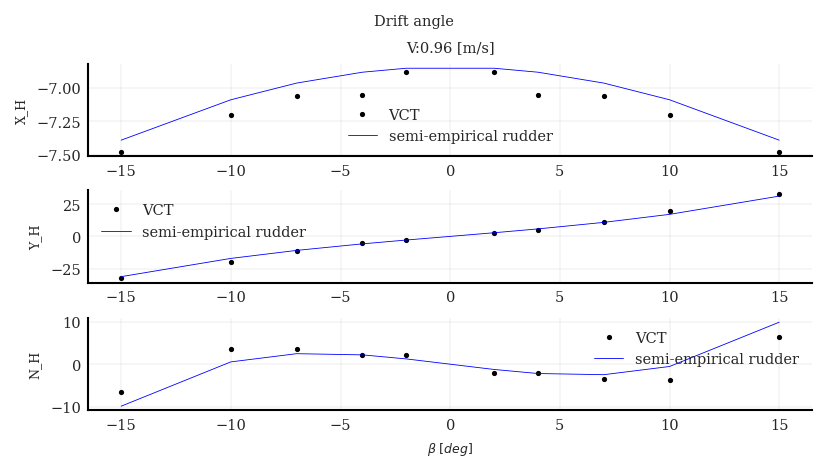

In [11]:
predictions = {
    "semiempirical rudder" : df_prediction,
}

plot_VCT(df_VCT=df_VCT, predictions=predictions, y_keys = ['X_H', 'Y_H', 'N_H'], test_type='Drift angle', styles=styles);

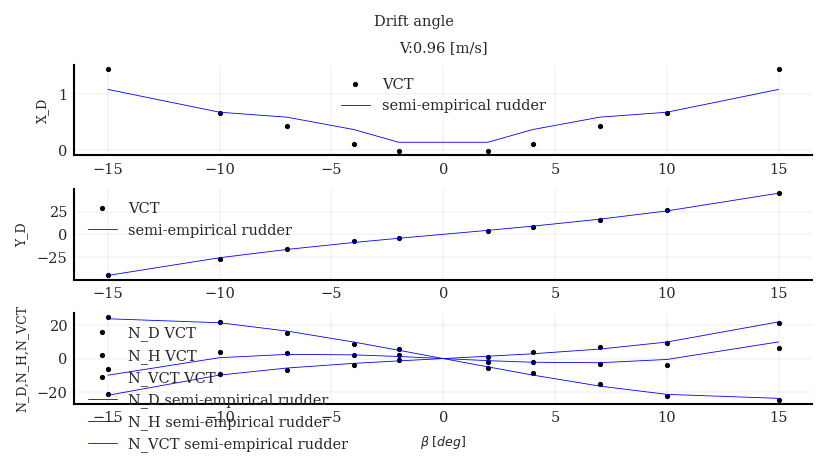

In [12]:
plot_VCT(df_VCT=df_VCT, predictions=predictions, y_keys=['X_D', 'Y_D', ['N_D','N_H','N_VCT']], test_type='Drift angle', styles=styles);

In [13]:
#df_VCT['X_P'] = df_VCT['thrust']

In [14]:
#df_prediction['X_H']+=df_prediction['thrust']*(1-model.parameters['Xthrustport'])

In [15]:
#df_prediction['X_D']+=df_prediction['thrust']*(1-model.parameters['Xthrustport'])

In [16]:
model.subsystems['hull'].equations['X_H']

Eq(X_H, X_{0} + X_{rr}*r**2 + X_{u}*u + X_{vr}*r*v + X_{vv}*v**2)

In [17]:
color_palette = ['k','b','r','m']
colors={}
for dof in ['X','Y','N']:
    color_all = color_palette.copy()
    for subscript in ['D','H','R','P']:
        key = f"{dof}_{subscript}"
        colors[key] = color_all.pop(0)
        

Text(0, 0.5, 'Surge forces $X$ $[N]$')

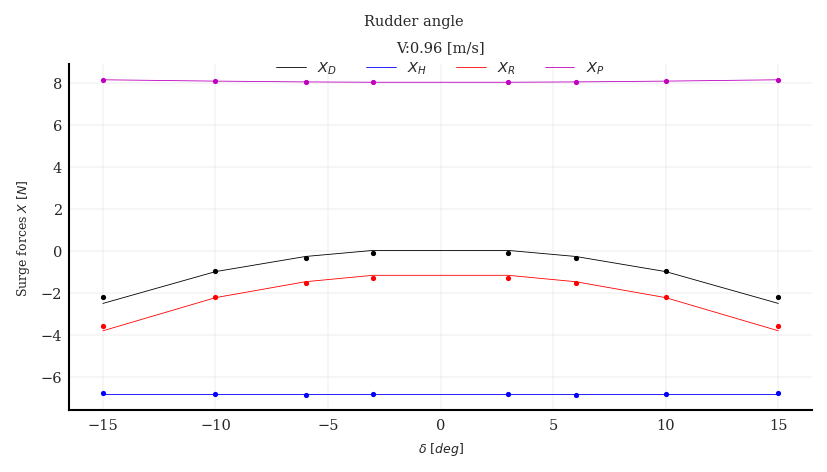

In [18]:
fig = plot_VCT_components(df_VCT=df_VCT, df_prediction=df_prediction, y_keys=[['X_D','X_H','X_R','X_P'],], test_type='Rudder angle', 
                    colors=colors);
#fig.axes[0].legend(loc='upper left', ncols=4)
fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.50, 1.05), ncol=4)
fig.axes[0].set_ylabel(r'Surge forces $X$ $[N]$')

Text(0, 0.5, 'Surge forces $X$ $[N]$')

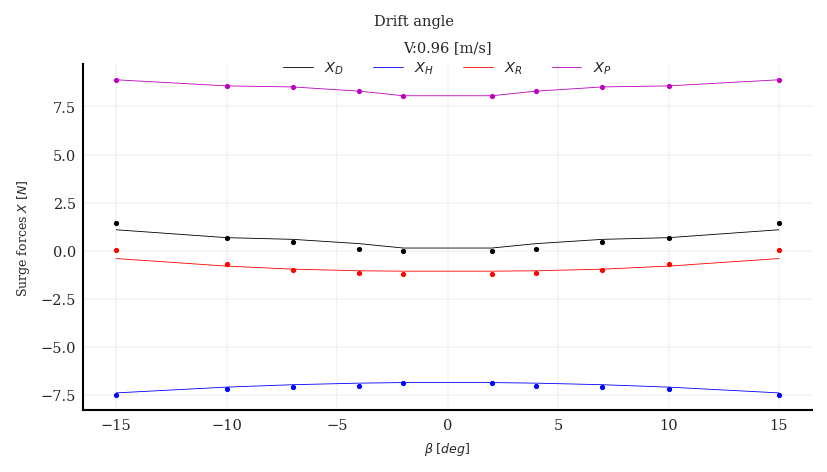

In [19]:
fig = plot_VCT_components(df_VCT=df_VCT, df_prediction=df_prediction, y_keys=[['X_D','X_H','X_R','X_P'],], test_type='Drift angle', 
                    colors=colors);
#fig.axes[0].legend(loc='upper left', ncols=4)
fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.50, 1.05), ncol=4)
fig.axes[0].set_ylabel(r'Surge forces $X$ $[N]$')

Text(0, 0.5, 'Yawing moment $N$ $[Nm]$')

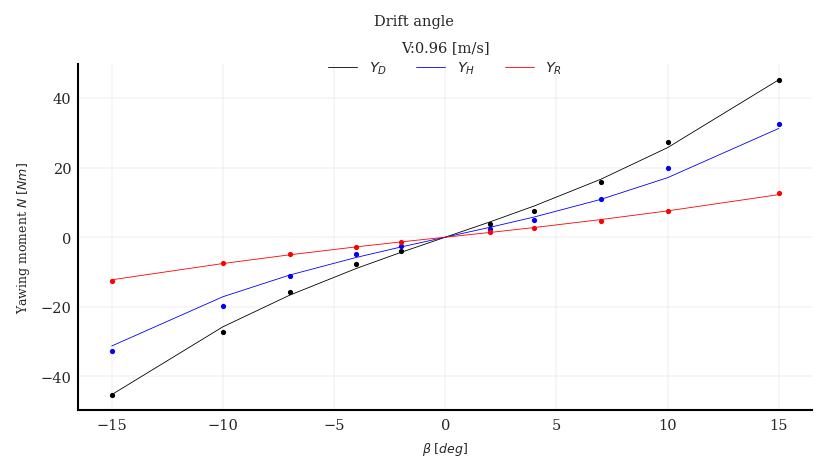

In [20]:
fig = plot_VCT_components(df_VCT=df_VCT, df_prediction=df_prediction, y_keys=[['Y_D','Y_H','Y_R'],], test_type='Drift angle', 
                    colors=colors);
fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.50, 1.05), ncol=3)
fig.axes[0].set_ylabel(r'Yawing moment $N$ $[Nm]$')

Text(0, 0.5, 'Yawing moment $N$ $[Nm]$')

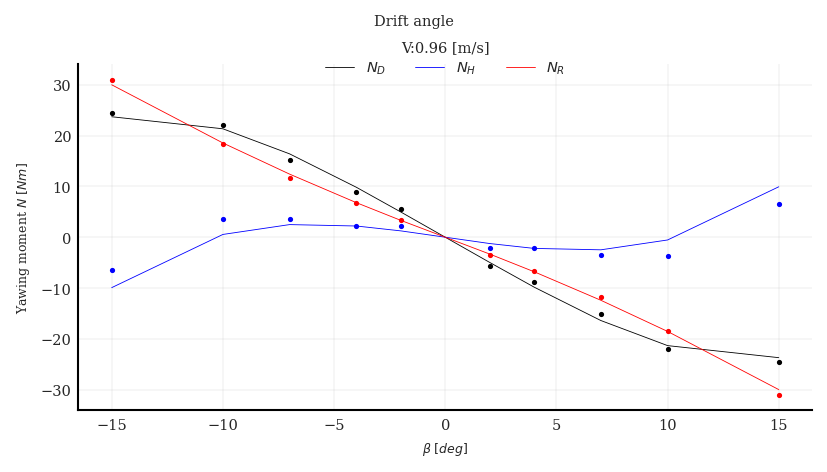

In [21]:
fig = plot_VCT_components(df_VCT=df_VCT, df_prediction=df_prediction, y_keys=[['N_D','N_H','N_R'],], test_type='Drift angle', 
                    colors=colors);
fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.50, 1.05), ncol=3)
fig.axes[0].set_ylabel(r'Yawing moment $N$ $[Nm]$')

In [22]:
1-model.parameters['Xthrustport']

0.11699999999999999

In [23]:
df_VCT_prime = model.prime(df_VCT)

In [24]:
df_VCT_prime.groupby(by='test type').get_group('self propulsion')[['X_H']]

,X_H
59,-0.000589
60,-0.000662
